In [2]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
torch.random.manual_seed(42)
np.random.seed(42)

env = gym.make('LunarLander-v2')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
env.seed(42)


class LunarLanderSolver:
    def __init__(self, hidden_size, input_size, output_size, learning_rate, eps):
        self.model = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size, bias=False),
            nn.Softmax(dim=-1)
        ).cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate,eps=eps)
        self.reset()

    def forward(self, x):
        return self.model(x)

    def reset(self):
        self.episode_actions = torch.tensor([], requires_grad=True).cuda()
        self.episode_rewards = []

    

    def backward(self):
        future_reward = 0
        rewards = []
        for r in self.episode_rewards[::-1]:
            future_reward = r + gamma * future_reward
            rewards.append(future_reward)
        rewards = torch.tensor(rewards[::-1], dtype=torch.float32).cuda()
        rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
        loss = torch.sum(torch.mul(self.episode_actions, rewards).mul(-1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset()
        return loss.item()

batch_size = 10
gamma = 0.99


train_loss=0
batch_rewards = []
episode = 0
total_loss=[]
total_rewards=[]
model = LunarLanderSolver(hidden_size=1024, input_size=observation_space, output_size=action_space, learning_rate=1e-4, eps=1e-4)

for i in range(4000):
    observation = env.reset()
    done = False
    while not done:
        #env.render()
        frame = np.reshape(observation, [1, observation_space])
        action_probs = model.forward(torch.tensor(observation, dtype=torch.float32).cuda())
        distribution = Categorical(action_probs)
        action = distribution.sample()
        observation, reward, done, _ = env.step(action.item())
        model.episode_actions = torch.cat([model.episode_actions, distribution.log_prob(action).reshape(1)])
        model.episode_rewards.append(reward)
        if done:
            batch_rewards.append(np.sum(model.episode_rewards))
            loss=model.backward()
            train_loss+=loss
            episode += 1
            if episode % batch_size == 0:
                print('Batch: {}, average reward: {}'.format(episode // batch_size, np.array(batch_rewards).mean()))
                total_rewards.append(np.array(batch_rewards).mean())
                batch_rewards = []
                total_loss.append(train_loss/10)
                train_loss=0

Batch: 1, average reward: -226.5996898174041
Batch: 2, average reward: -158.99857736577457
Batch: 3, average reward: -141.20220506792558
Batch: 4, average reward: -129.04213122514983
Batch: 5, average reward: -175.70259214502565
Batch: 6, average reward: -136.3640294844709
Batch: 7, average reward: -110.67701424962338
Batch: 8, average reward: -199.72966002747526
Batch: 9, average reward: -167.57227236365387
Batch: 10, average reward: -124.78134049953061
Batch: 11, average reward: -227.77814271940628
Batch: 12, average reward: -159.9051213561096
Batch: 13, average reward: -167.98154998500243
Batch: 14, average reward: -218.147206511149
Batch: 15, average reward: -192.7031912269502
Batch: 16, average reward: -113.89210100983897
Batch: 17, average reward: -170.32594272210738
Batch: 18, average reward: -167.16670551835304
Batch: 19, average reward: -118.19229057375256
Batch: 20, average reward: -142.96973957270163
Batch: 21, average reward: -107.3784378338283
Batch: 22, average reward: -1

Batch: 177, average reward: -25.956410118349442
Batch: 178, average reward: -6.2454186150756925
Batch: 179, average reward: 4.057057912791401
Batch: 180, average reward: -61.08106474469567
Batch: 181, average reward: -75.48423981607911
Batch: 182, average reward: -52.942917310540224
Batch: 183, average reward: -34.8916278668288
Batch: 184, average reward: -43.33649117000737
Batch: 185, average reward: -7.538819095762664
Batch: 186, average reward: -50.271894335858256
Batch: 187, average reward: -16.609854045975702
Batch: 188, average reward: -42.13629792727136
Batch: 189, average reward: -49.81475995136667
Batch: 190, average reward: -20.174329495556492
Batch: 191, average reward: -45.74217234349617
Batch: 192, average reward: -5.524314654820129
Batch: 193, average reward: -10.673254974883811
Batch: 194, average reward: -9.884496023081756
Batch: 195, average reward: -38.56154624680353
Batch: 196, average reward: -42.42753530724342
Batch: 197, average reward: -24.95905167917623
Batch: 1

Batch: 353, average reward: 38.97071393115521
Batch: 354, average reward: 7.478956673788559
Batch: 355, average reward: 118.2218044437972
Batch: 356, average reward: 88.29180232021137
Batch: 357, average reward: 27.970030173976635
Batch: 358, average reward: 120.32579303906195
Batch: 359, average reward: 42.469177030420326
Batch: 360, average reward: 25.17959946237653
Batch: 361, average reward: 112.62606303700912
Batch: 362, average reward: 96.63048217048326
Batch: 363, average reward: 99.03678310226665
Batch: 364, average reward: 110.57520976579573
Batch: 365, average reward: 198.70888317576578
Batch: 366, average reward: 60.22053043359098
Batch: 367, average reward: 105.92871370529963
Batch: 368, average reward: 114.95546194907976
Batch: 369, average reward: 159.74840008244
Batch: 370, average reward: 91.44237920062591
Batch: 371, average reward: 122.51366415565163
Batch: 372, average reward: 141.31894058628077
Batch: 373, average reward: 90.5401908848801
Batch: 374, average reward:

C:\Users\xufan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\xufan\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


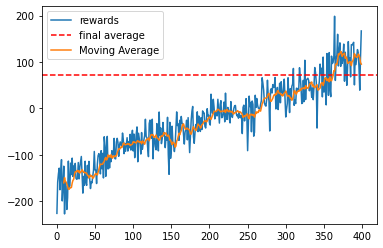

In [7]:
import matplotlib.pyplot as plt
plt.plot(total_rewards,label='rewards')
final=np.zeros(len(total_rewards))
lo=np.array(total_rewards)
plt.axhline(y=np.mean(total_rewards[-100:]),label='final average',linestyle='--',color='red')
for i in range(len(total_rewards)):
    final[i]=np.mean(lo[i-9:i])
plt.plot(final,label='Moving Average')
plt.legend()

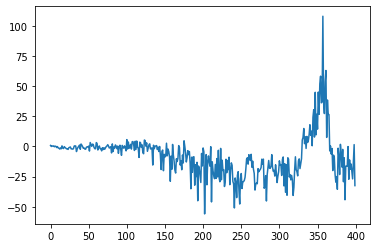

In [5]:
plt.plot(total_loss)